In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from scipy.stats import pearsonr
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import LeakyReLU  # this is already covered by import
import random
import seaborn as sns
import sklearn
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


import pathlib
import shutil
import tempfile

from tensorflow.python.ops.gen_sparse_ops import add_many_sparse_to_tensors_map

In [2]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 1.5])
    plt.title("Training and validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Error [MAE]")
    plt.legend()
    plt.grid(True)
    plt.show()

    
def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    ]

"""
def df_to_dataset(dataframe_X, dataframe_y, shuffle=True, batch_size=BATCH_SIZE):
    dataframe = dataframe_X.copy()
    labels = dataframe_y
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds
"""
# deal with batching


'\ndef df_to_dataset(dataframe_X, dataframe_y, shuffle=True, batch_size=BATCH_SIZE):\n    dataframe = dataframe_X.copy()\n    labels = dataframe_y\n    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))\n    if shuffle:\n        ds = ds.shuffle(buffer_size=len(dataframe))\n    ds = ds.batch(batch_size)\n    ds = ds.prefetch(batch_size)\n    return ds\n'

In [3]:
mag_df = pd.read_csv("../JET_EFIT_magnetic/99070_MAGC.csv",index_col=0)
#mag_df = mag_df.set_index("Time")
print(mag_df.shape)

efit_df = pd.read_csv("../JET_EFIT_magnetic/99070_EFIT.csv",index_col=0)
#efit_df = efit_df.set_index("Time")
print(efit_df.shape)

# merged should be 927 x 41

merged_df = mag_df.merge(efit_df, how="outer",on="Time")
merged_df = merged_df.dropna(axis=0)
pulse_data = merged_df
print(merged_df.head(2))
print(merged_df.shape)

(1061, 39)
(927, 3)
      BPME_0    BPME_1   BPME_10   BPME_11   BPME_12   BPME_13   BPME_14  \
35  0.000041  0.000129 -0.016841  0.006527 -0.017889 -0.061118 -0.011309   
36  0.000126 -0.000290 -0.000840  0.015001 -0.026383 -0.067135  0.000454   

     BPME_15   BPME_16  BPME_17  ...   FLME_38    FLME_7    FLME_8    FLME_9  \
35 -0.029960  0.005368 -0.05921  ...  0.898496 -0.023733  0.074144 -0.064945   
36 -0.057218  0.000487 -0.00163  ...  0.543274  0.005366  0.026649  0.019502   

        BVAC       FLX       IPLA   Time      FAXS      FBND  
35 -2.270235  0.001051 -242172.48  40.15 -1.116715 -1.025687  
36 -2.272149  0.001406 -236745.39  40.18 -1.123073 -1.011969  

[2 rows x 41 columns]
(927, 41)


In [14]:
"""
pulse_data = pd.read_csv("../JET_EFIT_magnetic/interpolated_99070.csv")
pulse_data = pulse_data.dropna(axis=0)
"""
y = pulse_data["FAXS"]
X = pulse_data.drop(["FAXS", "FBND", "Time"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=24
)

print(len(X_train), "train examples")
print(len(X_val), "validation examples")
print(len(X_test), "test examples")


592 train examples
149 validation examples
186 test examples


In [15]:

N_VALIDATION = int(len(X_val))
N_TRAIN = int(len(X_train))
BUFFER_SIZE = N_TRAIN
BATCH_SIZE = 50 # can crank this up
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE



lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def compile_and_fit(model, name, optimizer=None, max_epochs=100):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                 metrics='mean_absolute_error')

    model.summary()

    history = model.fit(
    X_train, y_train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(name),
    verbose=0)
    return history

In [16]:
"""
train_dataset = df_to_dataset(X_train, y_train, batch_size=BATCH_SIZE)
val_dataset = df_to_dataset(X_val, y_val, shuffle=False, batch_size=BATCH_SIZE)
test_dataset = df_to_dataset(X_test, y_test, shuffle=False, batch_size=BATCH_SIZE_SIZE)
"""
print('suppress output')

suppress output


In [17]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())

# figure out memory efficient read in

[ 2.3767650e-06 -4.7574143e-04 -3.2266594e-02 -2.8110569e-02
 -3.2766439e-02 -3.7593283e-02 -3.6562696e-02 -4.1417826e-02
 -4.4736523e-02 -4.9843192e-02 -5.6632172e-02 -1.3400409e-03
 -1.0451783e-03  2.1148766e-03  1.1418740e-02 -6.0083863e-04
  1.2562006e-02  2.5112419e-03 -2.0918988e-02 -2.4021726e-02
 -2.6293665e-02 -2.1949312e-02 -2.1788437e-02 -1.3369092e-02
 -1.9232241e-02 -1.1121899e-02 -1.0476898e-02 -8.6549986e-03
 -8.0897454e-03 -6.0594669e-03  2.5254289e-02  2.0997068e-02
 -2.6153300e-02 -2.5028795e-02 -2.3406498e-02 -2.3329859e+00
  6.0952120e-02 -1.7627329e+06]


### Tiny model

In [18]:
tiny_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 38)                77        
_________________________________________________________________
dense_14 (Dense)             (None, 16)                624       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 718
Trainable params: 641
Non-trainable params: 77
_________________________________________________________________


### Small model

In [19]:
small_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(16, activation='elu'),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 38)                77        
_________________________________________________________________
dense_16 (Dense)             (None, 16)                624       
_________________________________________________________________
dense_17 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 990
Trainable params: 913
Non-trainable params: 77
_________________________________________________________________


### Medium model


In [20]:
medium_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 38)                77        
_________________________________________________________________
dense_19 (Dense)             (None, 64)                2496      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 10,958
Trainable params: 10,881
Non-trainable params: 77
_________________________________________________________________


### Too large model

In [21]:
large_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

size_histories['large'] = compile_and_fit(large_model, "sizes/large")


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 38)                77        
_________________________________________________________________
dense_23 (Dense)             (None, 512)               19968     
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 513       
Total params: 808,526
Trainable params: 808,449
Non-trainable params: 77
_______________________________________________

(0.2, 1.5)

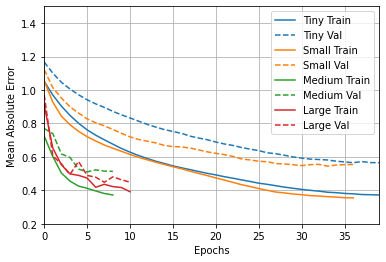

In [22]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(size_histories)
plt.ylim([0.2, 1.5])


Text(0.5, 0, 'Epochs [Log Scale]')

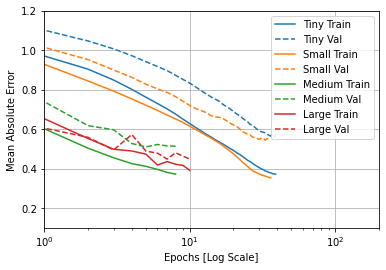

In [23]:
plotter.plot(size_histories)
a = plt.xscale('log')
#plt.xlim([1, max(plt.xlim())])
plt.xlim([1, 200])
plt.legend(loc="upper right")
plt.ylim([0.1, 1.2])
plt.xlabel("Epochs [Log Scale]")


## Regularisation

In [24]:
regularizer_histories = {}
regularizer_histories['Small'] = size_histories['Small']


In [25]:
l2_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['Largel2'] = compile_and_fit(l2_model, "regularizers/Largel2")


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 38)                77        
_________________________________________________________________
dense_28 (Dense)             (None, 512)               19968     
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 513       
Total params: 808,526
Trainable params: 808,449
Non-trainable params: 77
_______________________________________________

In [26]:
dropout_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 38)                77        
_________________________________________________________________
dense_33 (Dense)             (None, 512)               19968     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [27]:
combined_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['Largel2dropout'] = compile_and_fit(combined_model, "regularizers/Largel2dropout")

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 38)                77        
_________________________________________________________________
dense_38 (Dense)             (None, 512)               19968     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)             

In [28]:
attempt_l2_dropout = tf.keras.Sequential([
    normalizer,
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, 
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.01),
    layers.Dense(1)
])



regularizer_histories['attempt'] = compile_and_fit(attempt_l2_dropout, "regularizers/attempt")

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 38)                77        
_________________________________________________________________
dense_43 (Dense)             (None, 512)               19968     
_________________________________________________________________
dense_44 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_45 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_46 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)               

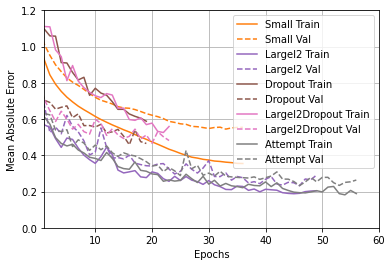

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0, 1.2])
plt.xlim([1, 60])
plt.legend(loc="upper right")


Text(0.5, 0, 'Epochs [Log Scale]')

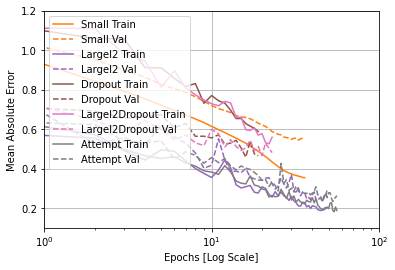

In [35]:
plotter.plot(regularizer_histories)
a = plt.xscale('log')
#plt.xlim([1, max(plt.xlim())])
plt.xlim([1, 100])
plt.legend(loc="upper left")
plt.ylim([0.1, 1.2])
plt.xlabel("Epochs [Log Scale]")


MAE down to 0.3!

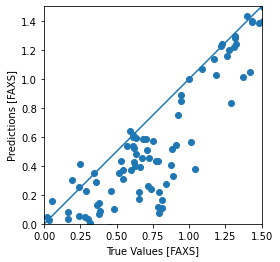

In [30]:
y_pred = attempt_l2_dropout.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [FAXS]')
plt.ylabel('Predictions [FAXS]')
lims = [0, 1.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

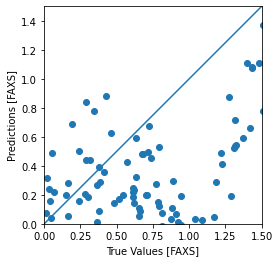

In [37]:
y_pred = small_model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [FAXS]')
plt.ylabel('Predictions [FAXS]')
lims = [0, 1.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Question: do the probes even help?

### Only probes

In [38]:
probe_test = {}
probe_test['combined'] = regularizer_histories['attempt']

y = pulse_data["FAXS"]
X = pulse_data.drop(["FAXS", "FBND", "Time","BVAC", "FLX", "IPLA"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=24
)

normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))



In [39]:
attempt_l2_dropout = tf.keras.Sequential([
    normalizer,
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, 
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.01),
    layers.Dense(1)
])


probe_test['only_probes'] = compile_and_fit(attempt_l2_dropout, "probe_test/only_probes")


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 35)                71        
_________________________________________________________________
dense_48 (Dense)             (None, 512)               18432     
_________________________________________________________________
dense_49 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_50 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_51 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)               

### Only EFIT

In [40]:
y = pulse_data["FAXS"]
X = pulse_data[["BVAC", "FLX", "IPLA"]]

#df1 = df[['a','d']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=24
)

normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [41]:
attempt_l2_dropout = tf.keras.Sequential([
    normalizer,
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, 
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.01),
    layers.Dense(1)
])


probe_test['only_EFIT'] = compile_and_fit(attempt_l2_dropout, "probe_test/only_EFIT")


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_53 (Dense)             (None, 512)               2048      
_________________________________________________________________
dense_54 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_55 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_56 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)               

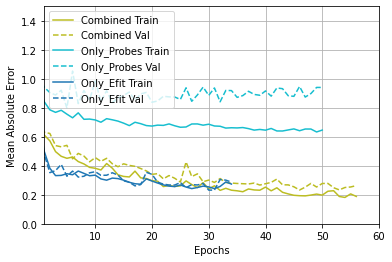

In [46]:
plotter.plot(probe_test)
plt.ylim([0, 1.5])
plt.xlim([1, 60])
plt.legend(loc="upper left")

Text(0.5, 0, 'Epochs [Log Scale]')

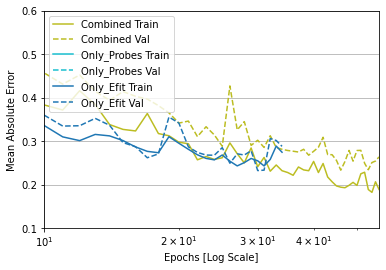

In [50]:
plotter.plot(probe_test)
a = plt.xscale('log')
plt.xlim([10, max(plt.xlim())])
#plt.xlim([1, 100])
plt.legend(loc="upper left")
plt.ylim([0.1, 0.6])
plt.xlabel("Epochs [Log Scale]")
